In [1]:

import site
site.addsitedir('/accounts/projects/jsteinhardt/fjiahai/coref/')

from importlib import reload
import os
from coref import COREF_ROOT
from coref.utils import cache
from functools import partial
import itertools
import gc

import torch
import pandas as pd

import coref.models as models
import coref.experiments.triplet_expts as te
import coref.datasets.templates.triplet as tt

from functools import partial
import numpy as np
import torch
import einops
import torch.nn.functional as F

import coref.datasets.templates.simple as ts
import coref.datasets.templates.common as tc
import coref.datasets.templates.triplet as tt
import coref.datasets.domains.simple as simple_domains
import coref.datasets.api as ta
import coref.parameters as p
import coref.datascience as ds
import coref.expt_utils as eu

import coref.interventions as cint
import coref.injection_interventions as ii

import coref.hf_interventions as hfint

import coref.flow as flow
import coref.eval_subspace as ess

import coref.saliency as sal

from tqdm.notebook import trange, tqdm

import coref.probes.centroid_probe as centroid_probe


import coref.probes.activation_localization as act_loc

import lets_plot as lp

lp.LetsPlot.setup_html()

def array_to_dict(arr, labels=None, val_label='value'):
    '''
    Basically a n-dimensional wide to long converter
    Args:
        arr: np.array
        labels: Optional[List[str]]
        val_label: Optional[str]
        
    Returns:
        dict(
            val_label: np.array
            labels[0]: np.array
            ...
        )
    '''
    if labels is not None:
        assert len(arr.shape) == len(labels)
    else:
        labels = [str(x) for x in range(len(arr.shape))]
    coords = [vals.flatten() for vals in np.meshgrid(*[np.arange(d) for d in arr.shape], indexing='ij')]
    return {
        val_label: np.array([arr[coord]for coord in zip(*coords)]),
    } | {
        label: xes
        for label, xes in zip(labels, coords)
    }
        
    

def std_plot(arr, feat_label='x'):
    '''
    Computes mean, mean-std_dev and mean+std_dev of 2D array
    
    Args:
        arr: np.array[num_samples, dim]
    Returns:
        dict(
            'mean': np.array[dim]
            'low': np.array[dim]
            'high': np.array[dim]
        )
    '''
    mean = arr.mean(axis=0)
    std = arr.std(axis=0)
    return {
        'mean': mean,
        'low': mean - std,
        'high': mean + std,
        feat_label: np.arange(len(mean))
    }
        
    

In [8]:
from coref.datasets.domains.common import set_prompt_id

In [4]:
MODEL_TAG = "Llama-2-13b-chat-hf"
NUM_DEVICES = 8
model = models.fetch_model(MODEL_TAG, num_devices=NUM_DEVICES, dtype=torch.float32, hf=False, device=0)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model llama-13b-hf into HookedTransformer


# Integrated

In [66]:
reload(centroid_probe)

<module 'coref.probes.centroid_probe' from '/accounts/projects/jsteinhardt/fjiahai/coref/coref/probes/centroid_probe.py'>

Normal log_prob: -18.38368797302246
Abnormal log_prob: -0.00159282679669559
Normal log_prob: -18.25264549255371
Abnormal log_prob: -0.0011757659958675504
Normal log_prob: -16.228008270263672
Abnormal log_prob: -0.005988197401165962
Normal log_prob: -16.810754776000977
Abnormal log_prob: -0.004140205215662718


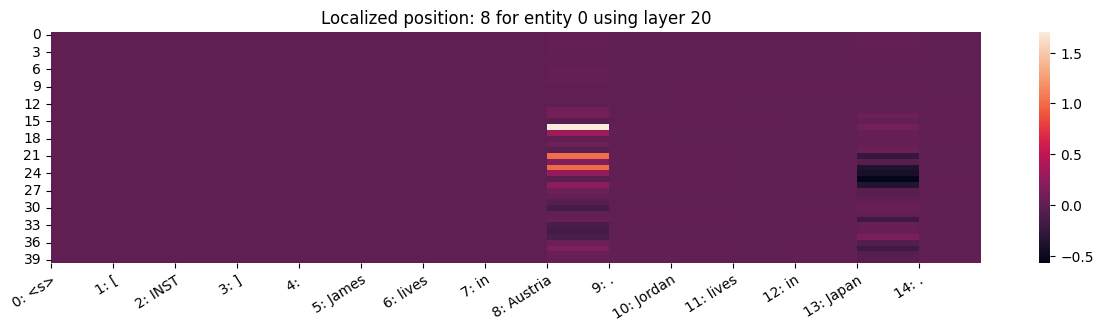

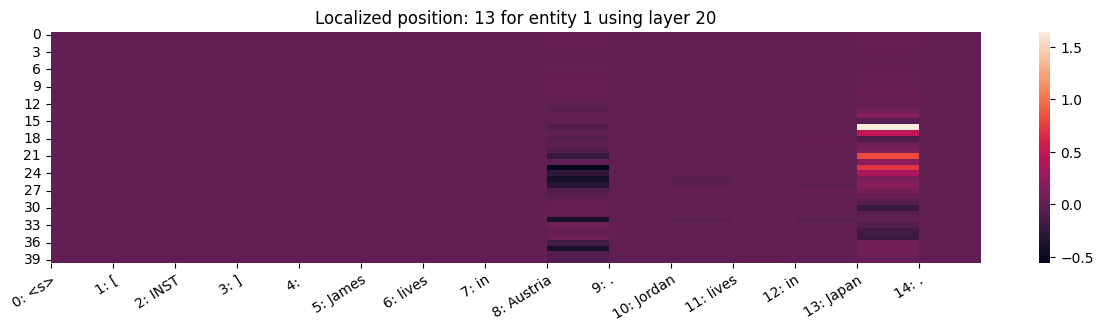

In [5]:
country_probe = centroid_probe.CountryCentroidProbe(model)

Normal log_prob: -21.539819717407227
Abnormal log_prob: -0.03024059161543846
Normal log_prob: -21.699785232543945
Abnormal log_prob: -0.018813209608197212
Normal log_prob: -22.91347312927246
Abnormal log_prob: -0.010121879167854786
Normal log_prob: -22.127971649169922
Abnormal log_prob: -0.01666877791285515


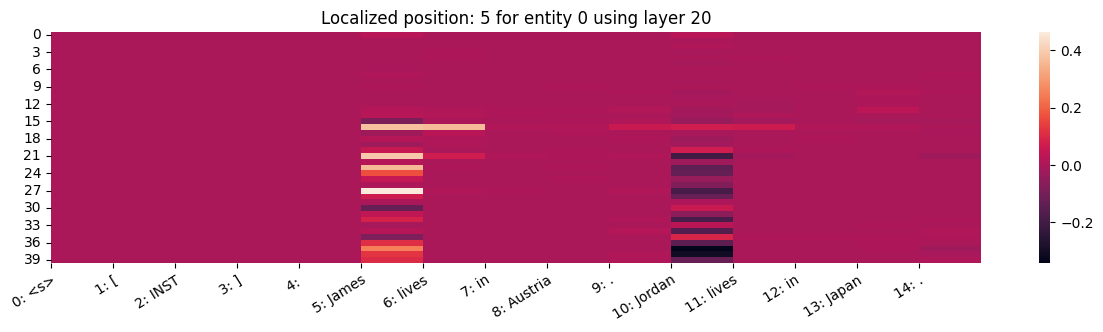

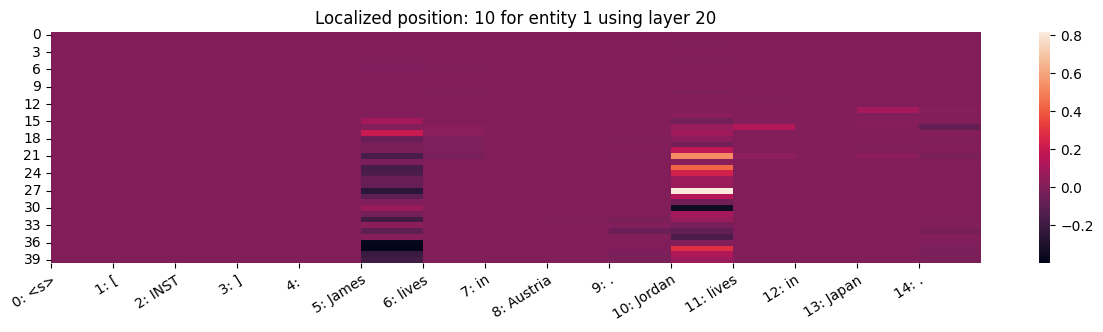

In [6]:
name_probe = centroid_probe.NameCentroidProbe(model)

Normal log_prob: -15.193514823913574
Abnormal log_prob: -2.0608067512512207
Normal log_prob: -15.491039276123047
Abnormal log_prob: -2.390399217605591
Normal log_prob: -16.340253829956055
Abnormal log_prob: -0.6638461351394653
Normal log_prob: -16.202497482299805
Abnormal log_prob: -1.0879969596862793


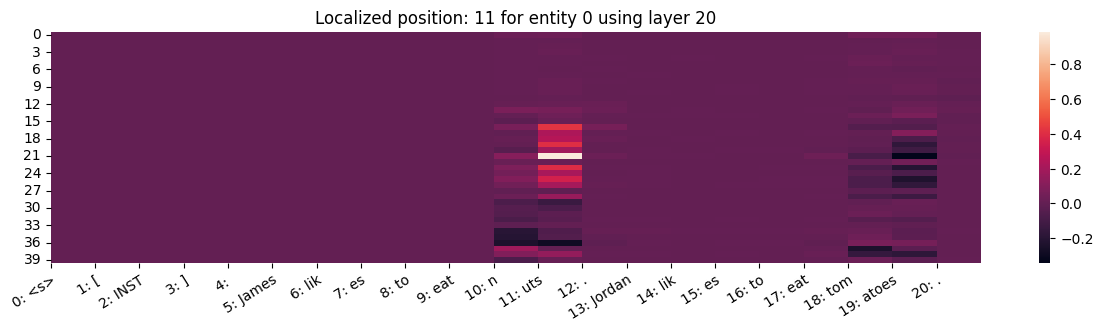

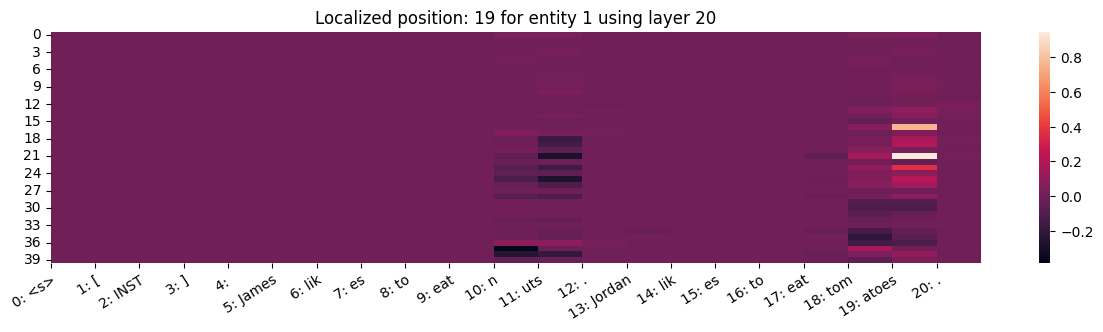

In [7]:
food_probe = centroid_probe.FoodCentroidProbe(model)

In [9]:
def evaluate_domain_probe(model, probe, source_context, true_answers, num_entities, num_samples, batch_size, template, domain):
    all_all_scores = []
    extra_stuff = []
    missing_stuff = []
    num_positions = []
    for c_slice in eu.generate_slices(0, num_samples, batch_size):
        source_tokens, answer_tokens, stacked_token_maps = p.build_example(
            batch_size=c_slice.stop - c_slice.start,
            template=template,
            template_content=dict(query_name=0),
            context_content=source_context,
            prompt_id_start=c_slice.start,
            num_answers=num_entities
        )
        _, source_cache = act_loc.get_normal_cache(
            model,
            input_tokens=source_tokens,
            prompt_ids=None, # not used
            stacked_token_maps=stacked_token_maps,
            answer_tokens=answer_tokens,
        )
        acts = einops.rearrange(
            torch.stack([source_cache[f'blocks.{layer}.hook_resid_pre'].cpu() for layer in range(model.cfg.n_layers)]),
            'layer batch pos dim -> batch layer pos dim'
        )
        norm_acts = acts / acts.norm(dim=-1, keepdim=True)
        probe_results = probe(norm_acts)
        grounded_answers = []
        preds = []
        for prompt_id in range(c_slice.start, c_slice.stop):
            with set_prompt_id(prompt_id, domain):
                grounded_answers.append([
                    domain.perm[ans] for ans in true_answers
                ])
        c_num_positions = (probe_results >= 0).sum(dim=1)
        for batch, ans in zip(probe_results, grounded_answers):
            # batch : [pos]
            okay = 0
            extra = 0
            missing = 0
            for a in ans:
                if (batch == a).any():
                    okay += 1
                else:
                    missing += 1
            for x in batch:
                if x != -1 and x not in ans:
                    extra += 1
            extra_stuff.append(extra)
            missing_stuff.append(missing)
        num_positions.append(c_num_positions.cpu().tolist())
    return extra_stuff, missing_stuff, sum(num_positions, [])

In [11]:

from coref.datasets.templates.fixed import NameCountryFoodFixedTemplate

In [12]:
fixed_template = NameCountryFoodFixedTemplate('llama', 'train')

In [13]:
food_probe.threshold = 5

extra_stuff, missing_stuff, num_positions = evaluate_domain_probe(
    model=model, 
    probe=food_probe,
    source_context=[tc.TStatement(list(range(2)), list(range(2)),list(range(2)), None)],
    true_answers=[0,1],
    num_entities=2,
    num_samples=50,
    batch_size=50,
    template=fixed_template,
    domain=fixed_template.foods
)

print(f'Extra: {np.array(extra_stuff).mean()}')
print(f'Mising: {np.array(missing_stuff).mean()}')
print(f'Positions: {np.array(num_positions).mean()}')

Extra: 0.36
Mising: 0.0
Positions: 4.0


In [14]:
country_probe.threshold = 5

extra_stuff, missing_stuff, num_positions = evaluate_domain_probe(
    model=model, 
    probe=country_probe,
    source_context=[tc.TStatement(list(range(2)), list(range(2)),list(range(2)), None)],
    true_answers=[0,1],
    num_entities=2,
    num_samples=50,
    batch_size=50,
    template=fixed_template,
    domain=fixed_template.capitals
)

print(f'Extra: {np.array(extra_stuff).mean()}')
print(f'Mising: {np.array(missing_stuff).mean()}')
print(f'Positions: {np.array(num_positions).mean()}')

Extra: 0.0
Mising: 0.0
Positions: 2.1


In [15]:
name_probe.threshold = 6

extra_stuff, missing_stuff, num_positions = evaluate_domain_probe(
    model=model, 
    probe=name_probe,
    source_context=[tc.TStatement(list(range(2)), list(range(2)),list(range(2)), None)],
    true_answers=[0,1],
    num_entities=2,
    num_samples=50,
    batch_size=50,
    template=fixed_template,
    domain=fixed_template.names
)

print(f'Extra: {np.array(extra_stuff).mean()}')
print(f'Mising: {np.array(missing_stuff).mean()}')
print(f'Positions: {np.array(num_positions).mean()}')

Extra: 0.16
Mising: 0.0
Positions: 6.48


# Binding subspace

In [22]:
import coref.form_processors

In [35]:
def U_subspace_affinity_fn(norm_acts, form, layer=15, dim=50):
    subs = einops.einsum(
        norm_acts[:, layer].cuda(),
        (form.U[:, :dim] * form.S[:dim]) @ form.U[:, :dim].T,
        norm_acts[:, layer].cuda(),
        "batch pos dim, dim dim2, batch pos2 dim2 -> batch pos pos2"
    )
    return subs

In [24]:
form_path = "/accounts/projects/jsteinhardt/fjiahai/coref/runs/point_hessians/llama_13b_chat_widths_1_1/0/hessian.pt"
form_type = "hessian_1_1"


In [46]:
def get_cache(model, template, c_slice, source_context, num_entities):
    source_tokens, answer_tokens, stacked_token_maps = p.build_example(
        batch_size=c_slice.stop - c_slice.start,
        template=template,
        template_content=dict(query_name=0),
        context_content=source_context,
        prompt_id_start=c_slice.start,
        num_answers=num_entities
    )
    _, source_cache = act_loc.get_normal_cache(
        model,
        input_tokens=source_tokens,
        prompt_ids=None, # not used
        stacked_token_maps=stacked_token_maps,
        answer_tokens=answer_tokens,
    )
    return source_cache, source_tokens
def cache_to_norm_acts(model, cache):
    acts = einops.rearrange(
        torch.stack([cache[f'blocks.{layer}.hook_resid_pre'].cpu() for layer in range(model.cfg.n_layers)]),
        'layer batch pos dim -> batch layer pos dim'
    )
    norm_acts = acts / acts.norm(dim=-1, keepdim=True)
    return norm_acts

In [47]:
cache, tokens = get_cache(
    model,
    fixed_template,
    c_slice=slice(0, 10),
    source_context=[tc.TStatement(list(range(2)), list(range(2)),list(range(2)), None)],
    num_entities=2
)
norm_acts = cache_to_norm_acts(model, cache)

In [25]:
form = torch.load(form_path)

form = coref.form_processors.process_form(form, form_type)

In [36]:
gg = U_subspace_affinity_fn(norm_acts, form)

In [37]:
gg.shape

torch.Size([10, 142, 142])

In [48]:
batch = 0

In [51]:
(
    lp.ggplot(array_to_dict(gg[batch].cpu().numpy(), labels=['x', 'y'])) 
    + lp.geom_tile(lp.aes(x='x', y='y', fill='value'))
    + lp.scale_x_discrete(labels=[model.tokenizer.decode(x) + f'-{i}' for i, x in enumerate(tokens[batch])])
    + lp.scale_y_discrete(labels=[model.tokenizer.decode(x) + f'-{i}' for i, x in enumerate(tokens[batch])])
    + lp.ggsize(800, 800)
)

In [53]:
(
    lp.ggplot(array_to_dict(gg[batch, 4].cpu().numpy(), labels=['x'])) 
    + lp.geom_line(lp.aes(x='x', y='value'))
    + lp.scale_x_discrete(labels=[model.tokenizer.decode(x) for x in tokens[batch]])
    + lp.ggsize(800, 800)
)

<Axes: >

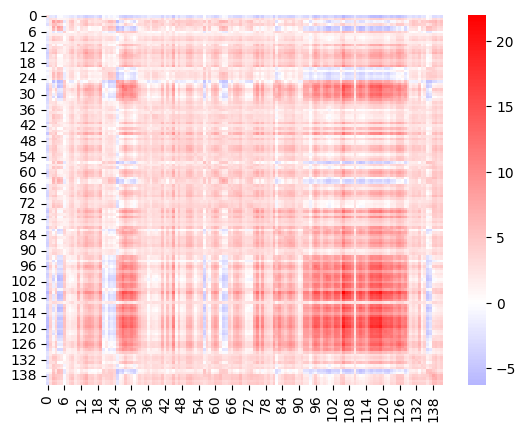

In [68]:
sns.heatmap(gg[batch].cpu().numpy(), cmap='bwr', center=0)

/accounts/projects/jsteinhardt/fjiahai/.conda/envs/coref/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/accounts/projects/jsteinhardt/fjiahai/.conda/envs/coref/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


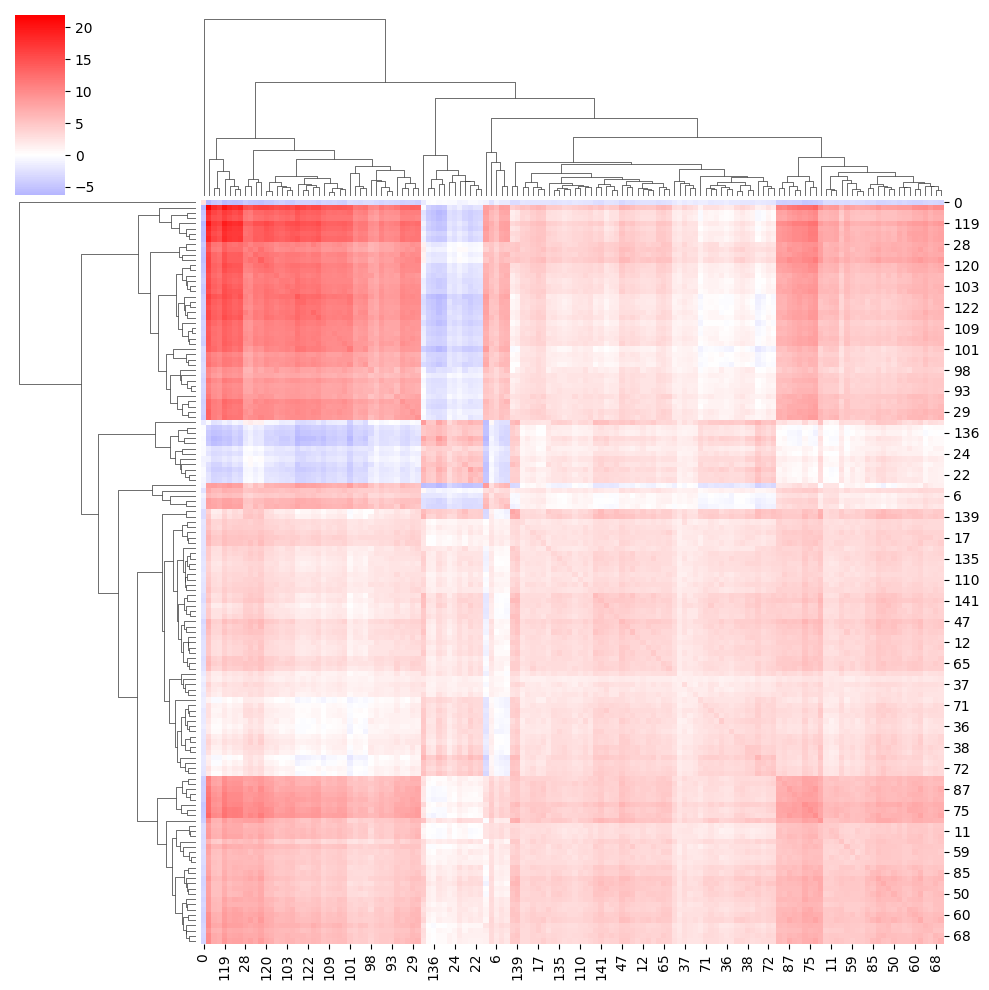

In [69]:
sns.clustermap(gg[batch].cpu().numpy(), cmap='bwr', center=0)

In [56]:
from sklearn.cluster import SpectralClustering

In [70]:
sc = SpectralClustering(affinity='precomputed', n_clusters=4)

In [71]:
sc.fit(np.exp(gg[batch].cpu().numpy()))

/accounts/projects/jsteinhardt/fjiahai/.conda/envs/coref/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


SpectralClustering(affinity='precomputed', n_clusters=4)

In [72]:
(
    lp.ggplot({
        **array_to_dict(gg[batch, 4].cpu().numpy(), labels=['x']),
        'cluster': sc.labels_
    }) 
    + lp.geom_line(lp.aes(x='x', y='value'))
    + lp.geom_point(lp.aes(x='x', y='value', color='cluster'))
    + lp.scale_x_discrete(labels=[model.tokenizer.decode(x) for x in tokens[batch]])
    + lp.scale_color_discrete()
    + lp.ggsize(800, 800)
)

# Name lookup

In [113]:
def propose_predicates(
    model,
    norm_acts,
    index_probe,
    other_probes,
    binding_affinity_fn,
):
    '''
    Args:
        norm_acts: Tensor[batch, layer, pos, dim]
        all_probes: List[DomainProbe]
        unique_probe: DomainProbe
        binding_affinity: (norm_acts: FloatTensor[batch, layer, pos, dim]) -> (affinity: FloatTensor[batch, pos, pos])
    
    Assumption: every attribute value is bound to some value of unique_probe
    '''
    num_batches, num_layers, num_pos, _ = norm_acts.shape
    binding_affinity = binding_affinity_fn(norm_acts)
    index_results = index_probe(norm_acts) # batch, pos
    other_results = [probe(norm_acts) for probe in other_probes]
    all_proposed_predicates = []
    for batch in range(num_batches):
        proposed_predicates = []
        for pos in range(num_pos):
            for probe, results in zip(other_probes, other_results):
                if results[batch, pos] != -1:
                    # find best unique_value using softmax
                    logits = binding_affinity[batch, pos, :]
                    mask = (index_results[batch, :] != -1)
                    masked_logits = torch.where(mask, logits, -torch.inf)
                    assert len(masked_logits.shape) == 1
                    pattern = F.softmax(masked_logits, dim=0)
                    pattern = torch.nan_to_num(pattern, 0)
                    scores = np.zeros(len(index_probe.values))
                    for i, p in enumerate(pattern):
                        scores[index_results[batch, i].item()] += p
                    
                    proposed_predicates.append((
                        scores.argmax().item(), 
                        results[batch, pos].item(),
                        probe.domain_name
                    ))
        all_proposed_predicates.append(proposed_predicates)
    return all_proposed_predicates
                    
    
    

In [128]:
def evaluate_probes(
    model,
    name_probe,
    country_probe,
    food_probe,
    form,
    num_samples,
    batch_size
):
    all_predicates = []
    all_true_predicates = []
    for c_slice in eu.generate_slices(0, num_samples, batch_size):
        cache, tokens = get_cache(
            model,
            fixed_template,
            c_slice=c_slice,
            source_context=[tc.TStatement(list(range(2)), list(range(2)),list(range(2)), None)],
            num_entities=2
        )
        norm_acts = cache_to_norm_acts(model, cache)
        predicates = propose_predicates(
            model=model,
            norm_acts=norm_acts,
            index_probe=name_probe,
            other_probes=[country_probe, food_probe],
            binding_affinity_fn=partial(U_subspace_affinity_fn, form=form),
        )
        all_predicates.append(predicates)
        for i in range(c_slice.start, c_slice.stop):
            c_true_predicate = []
            with set_prompt_id(i, fixed_template.names, fixed_template.capitals, fixed_template.foods):
                for entity in [0, 1]:
                    c_true_predicate.append((
                        fixed_template.names.perm[entity],
                        fixed_template.foods.perm[entity],
                        food_probe.domain_name
                    ))
                    c_true_predicate.append((
                        fixed_template.names.perm[entity],
                        fixed_template.capitals.perm[entity],
                        country_probe.domain_name
                    ))
            all_true_predicates.append(c_true_predicate)
    all_predicates = sum(all_predicates, [])
    acc = [set(true_predicates) == set(predicates) for true_predicates, predicates in zip(all_true_predicates, all_predicates)]
    return sum(acc)/len(acc), all_predicates, all_true_predicates
                
            

In [111]:
country_probe.domain_name = 'countries'
name_probe.domain_name = 'names'
food_probe.domain_name = 'foods'

In [116]:
acc, all_predicates, all_true_predicates = evaluate_probes(
    model=model,
    name_probe=name_probe,
    country_probe=country_probe,
    food_probe=food_probe,
    form=form,
    num_samples=100,
    batch_size=50
)
acc

0.69

In [122]:
for p, tp in zip(all_predicates, all_true_predicates):
    print(f'{set(p) == set(tp)}: {set(p)} vs {set(tp)}')
    if set(p) != set(tp):
        print(f'Extra: {set(p) - set(tp)}')
        print(f'Missing: {set(tp) - set(p)}')

True: {(30, 15, 'foods'), (1, 0, 'countries'), (1, 1, 'foods'), (30, 5, 'countries')} vs {(30, 15, 'foods'), (1, 0, 'countries'), (1, 1, 'foods'), (30, 5, 'countries')}
True: {(19, 14, 'foods'), (10, 13, 'foods'), (19, 1, 'countries'), (10, 8, 'countries')} vs {(19, 14, 'foods'), (10, 13, 'foods'), (19, 1, 'countries'), (10, 8, 'countries')}
True: {(6, 2, 'foods'), (0, 10, 'foods'), (6, 4, 'countries'), (0, 3, 'countries')} vs {(6, 4, 'countries'), (0, 3, 'countries'), (6, 2, 'foods'), (0, 10, 'foods')}
True: {(1, 4, 'countries'), (1, 13, 'foods'), (3, 6, 'countries'), (3, 2, 'foods')} vs {(3, 2, 'foods'), (1, 13, 'foods'), (1, 4, 'countries'), (3, 6, 'countries')}
True: {(13, 1, 'foods'), (13, 8, 'countries'), (8, 3, 'countries'), (8, 8, 'foods')} vs {(13, 1, 'foods'), (13, 8, 'countries'), (8, 3, 'countries'), (8, 8, 'foods')}
False: {(20, 13, 'foods'), (21, 8, 'countries'), (20, 0, 'countries'), (12, 6, 'foods')} vs {(21, 6, 'foods'), (21, 8, 'countries'), (20, 0, 'countries'), (20,

In [ ]:
from

In [97]:
model.tokenizer.decode(tokens[1])

'<s> [INST] Eric and Andrew were childhood friends who grew up in neighboring towns. While Eric called France home, Andrew lived across the border in Sweden. Despite their different upbringings, the two friends shared a passion for exploring the great outdoors. Eric particularly enjoyed indulging in cheese, a traditional dish from their region, and would often pack extras to share with Andrew on their hiking trips. In contrast, Andrew had a fondness for pork, a unique delicacy from their hometown, and would always make sure to bring some along for their outdoor adventures. [/INST] Therefore, Eric lives in the country of'

In [100]:
food_probe.threshold = 6

In [101]:
propose_predicates(
    model=model,
    norm_acts=norm_acts,
    index_probe=name_probe,
    other_probes=[country_probe, food_probe],
    binding_affinity_fn=partial(U_subspace_affinity_fn, form=form),
)

[[('James', ('Austria', 'Vienna')),
  ('Jordan', ('Japan', 'Tokyo')),
  ('James', 'nuts'),
  ('Jordan', 'tomatoes'),
  ('Jordan', 'tomatoes')],
 [('Eric', ('France', 'Paris')),
  ('Andrew', ('Sweden', 'Stockholm')),
  ('Eric', 'cheese'),
  ('Eric', 'cheese'),
  ('Andrew', 'pork')],
 [('Michael', ('Israel', 'Jerusalem')),
  ('Thomas', ('Italy', 'Rome')),
  ('Michael', 'bananas'),
  ('Michael', 'bananas'),
  ('Thomas', 'guavas')],
 [('Robert', ('Russia', 'Moscow')),
  ('James', ('Italy', 'Rome')),
  ('Robert', 'guavas'),
  ('James', 'pork')],
 [('Jason', ('Sweden', 'Stockholm')),
  ('Anthony', ('Israel', 'Jerusalem')),
  ('Jason', ('Sweden', 'Stockholm')),
  ('Jason', 'nuts'),
  ('Anthony', 'chicken')],
 [('Jonathan', ('Sweden', 'Stockholm')),
  ('Nicholas', ('Austria', 'Vienna')),
  ('Barbara', 'barley'),
  ('Nicholas', 'pork')],
 [('Daniel', ('Russia', 'Moscow')),
  ('George', ('Ireland', 'Dublin')),
  ('Daniel', 'donuts'),
  ('Daniel', 'donuts'),
  ('Daniel', 'donuts'),
  ('George', '